In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

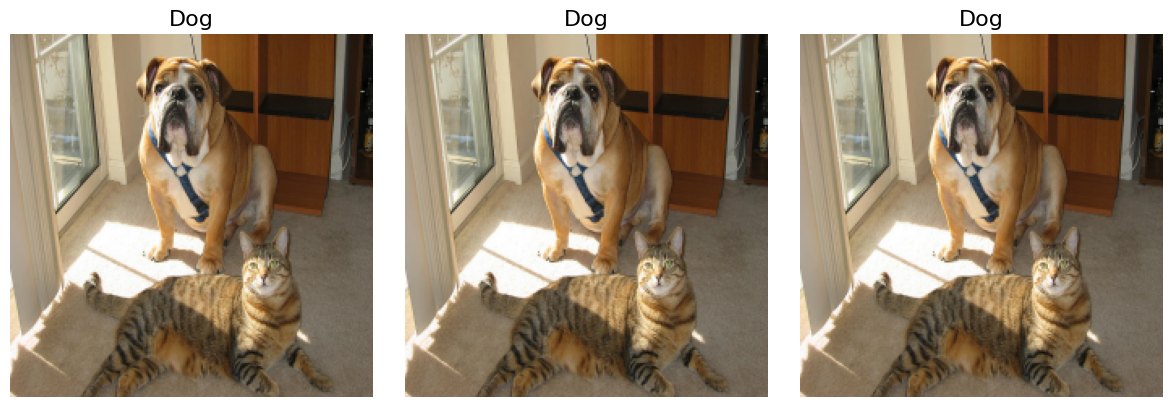

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

image_titles = ['Dog', 'Dog', 'Dog']

img1 = load_img('./cat_dog.png', target_size=(224, 224))
img2 = load_img('./cat_dog.png', target_size=(224, 224))
img3 = load_img('./cat_dog.png', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [4]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([1, 294, 413])

def score_function(output):
    return (output[0][1], output[1][294], output[2][413])

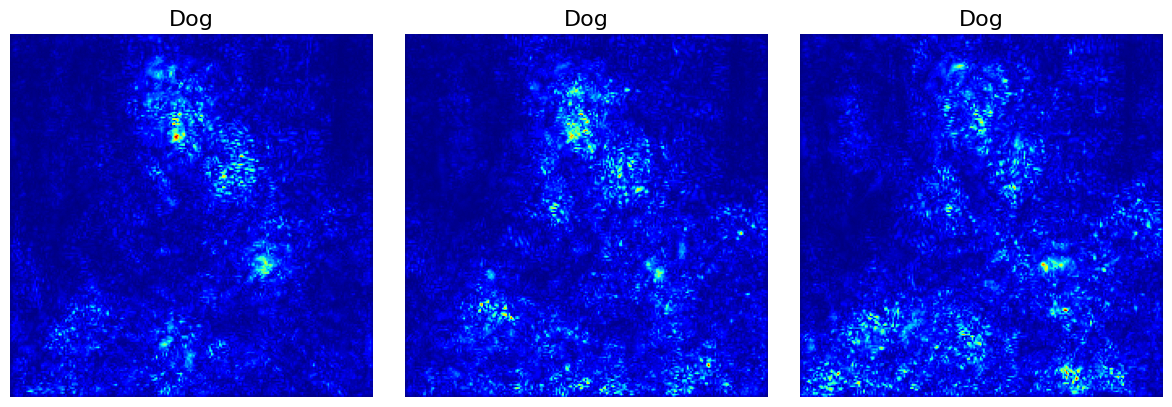

CPU times: user 18.6 s, sys: 1.37 s, total: 20 s
Wall time: 2.93 s


In [6]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

saliency_map = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

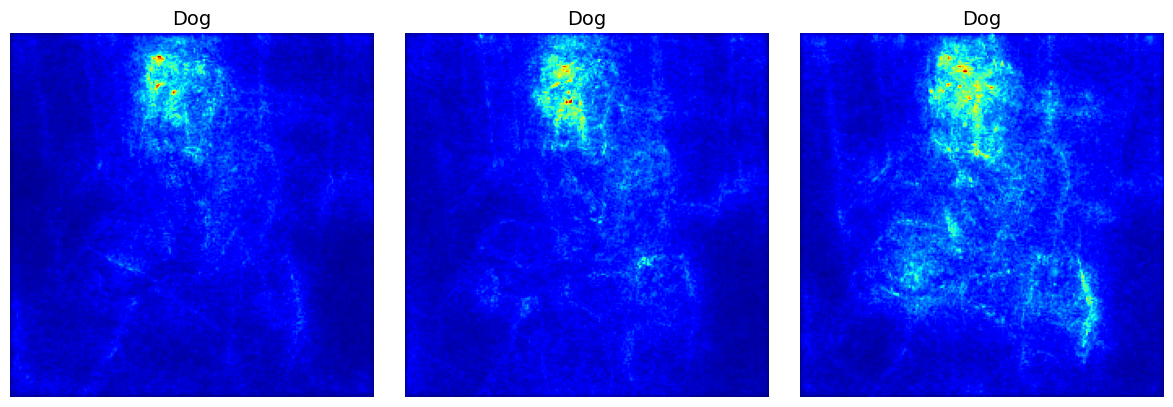

CPU times: user 5min 46s, sys: 6.3 s, total: 5min 52s
Wall time: 44.7 s


In [7]:
%%time
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

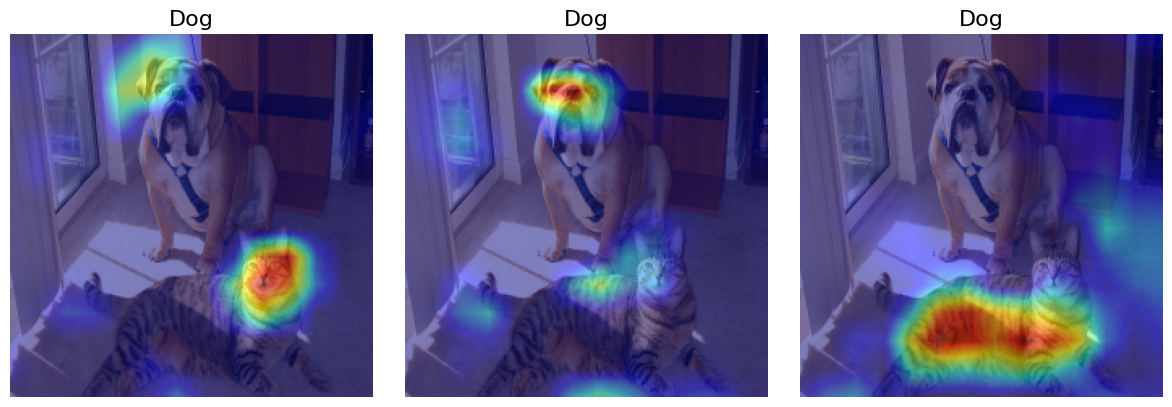

CPU times: user 20 s, sys: 1.32 s, total: 21.3 s
Wall time: 3.11 s


In [8]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

cam = gradcam(score,
              X,
              penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

2023-07-27 06:24:37.632086: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 924844032 exceeds 10% of free system memory.


48/48 [==============================] - 328s 7s/step


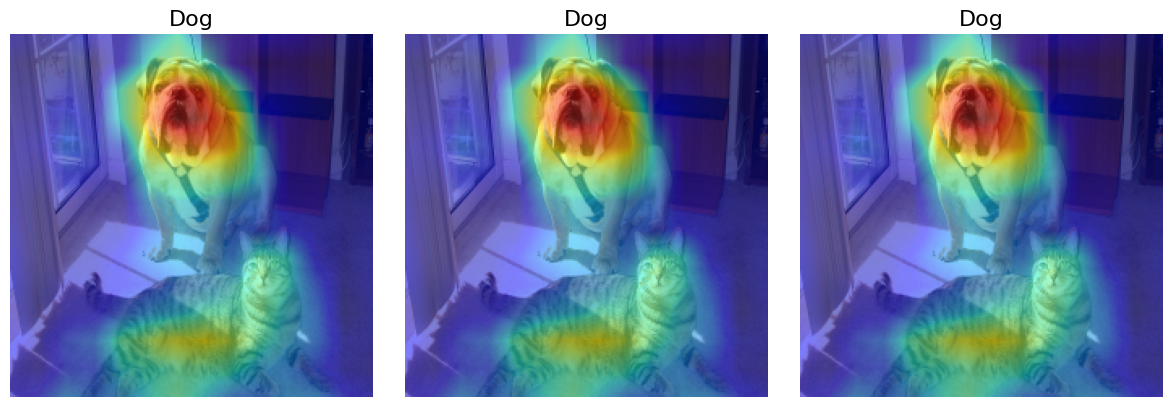

CPU times: user 45min 39s, sys: 40.4 s, total: 46min 19s
Wall time: 5min 39s


In [9]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

scorecam = Scorecam(model)

cam = scorecam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()